In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

#import pip
#import theano
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator



[nltk_data] Downloading package punkt to /Users/lanado/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lanado/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lanado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import pickle
with open('word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

with open('embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)


In [16]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

In [7]:
class AttentionLayer(Layer):
    """
    Hierarchical Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    TensorFlow backend
    """
    def __init__(self, attention_dim=100, return_coefficients=False, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        self.attention_dim = attention_dim

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], self.attention_dim),
                                 initializer=self.init,
                                 name='W')
        self.b = self.add_weight(shape=(self.attention_dim,),
                                 initializer=self.init,
                                 name='b')
        self.u = self.add_weight(shape=(self.attention_dim, 1),
                                 initializer=self.init,
                                 name='u')
        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, inputs, mask=None):
        hit = inputs
        uit = K.bias_add(K.dot(hit, self.W), self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, axis=-1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]


/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ word_input (InputLayer)         │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_embedding (Embedding)      │ (None, 50, 100)        │    80,270,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_gru (Bidirectional)        │ (None, 50, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_dense (Dense)              │ (None, 50, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_attention (AttentionLayer) │ [(None, 100), (None,   │        10,200 │
│                                 │ 100, 1)]               │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,336,300 (306.46 MB)

 Trainable params: 65,900 (257.42 KB)

 Non-trainable params: 80,270,400 (306.21 MB)

None


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sent_input (InputLayer)         │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sent_linking (TimeDistributed)  │ (None, 40, 100)        │    80,336,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sent_gru (Bidirectional)        │ (None, 40, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sent_dense (Dense)              │ (None, 40, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sent_attention (AttentionLayer) │ [(None, 100), (None,   │        10,200 │
│                                 │ 100, 1)]               │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sent_dropout (Dropout)          │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,402,705 (306.71 MB)

 Trainable params: 132,305 (516.82 KB)

 Non-trainable params: 80,270,400 (306.21 MB)

None


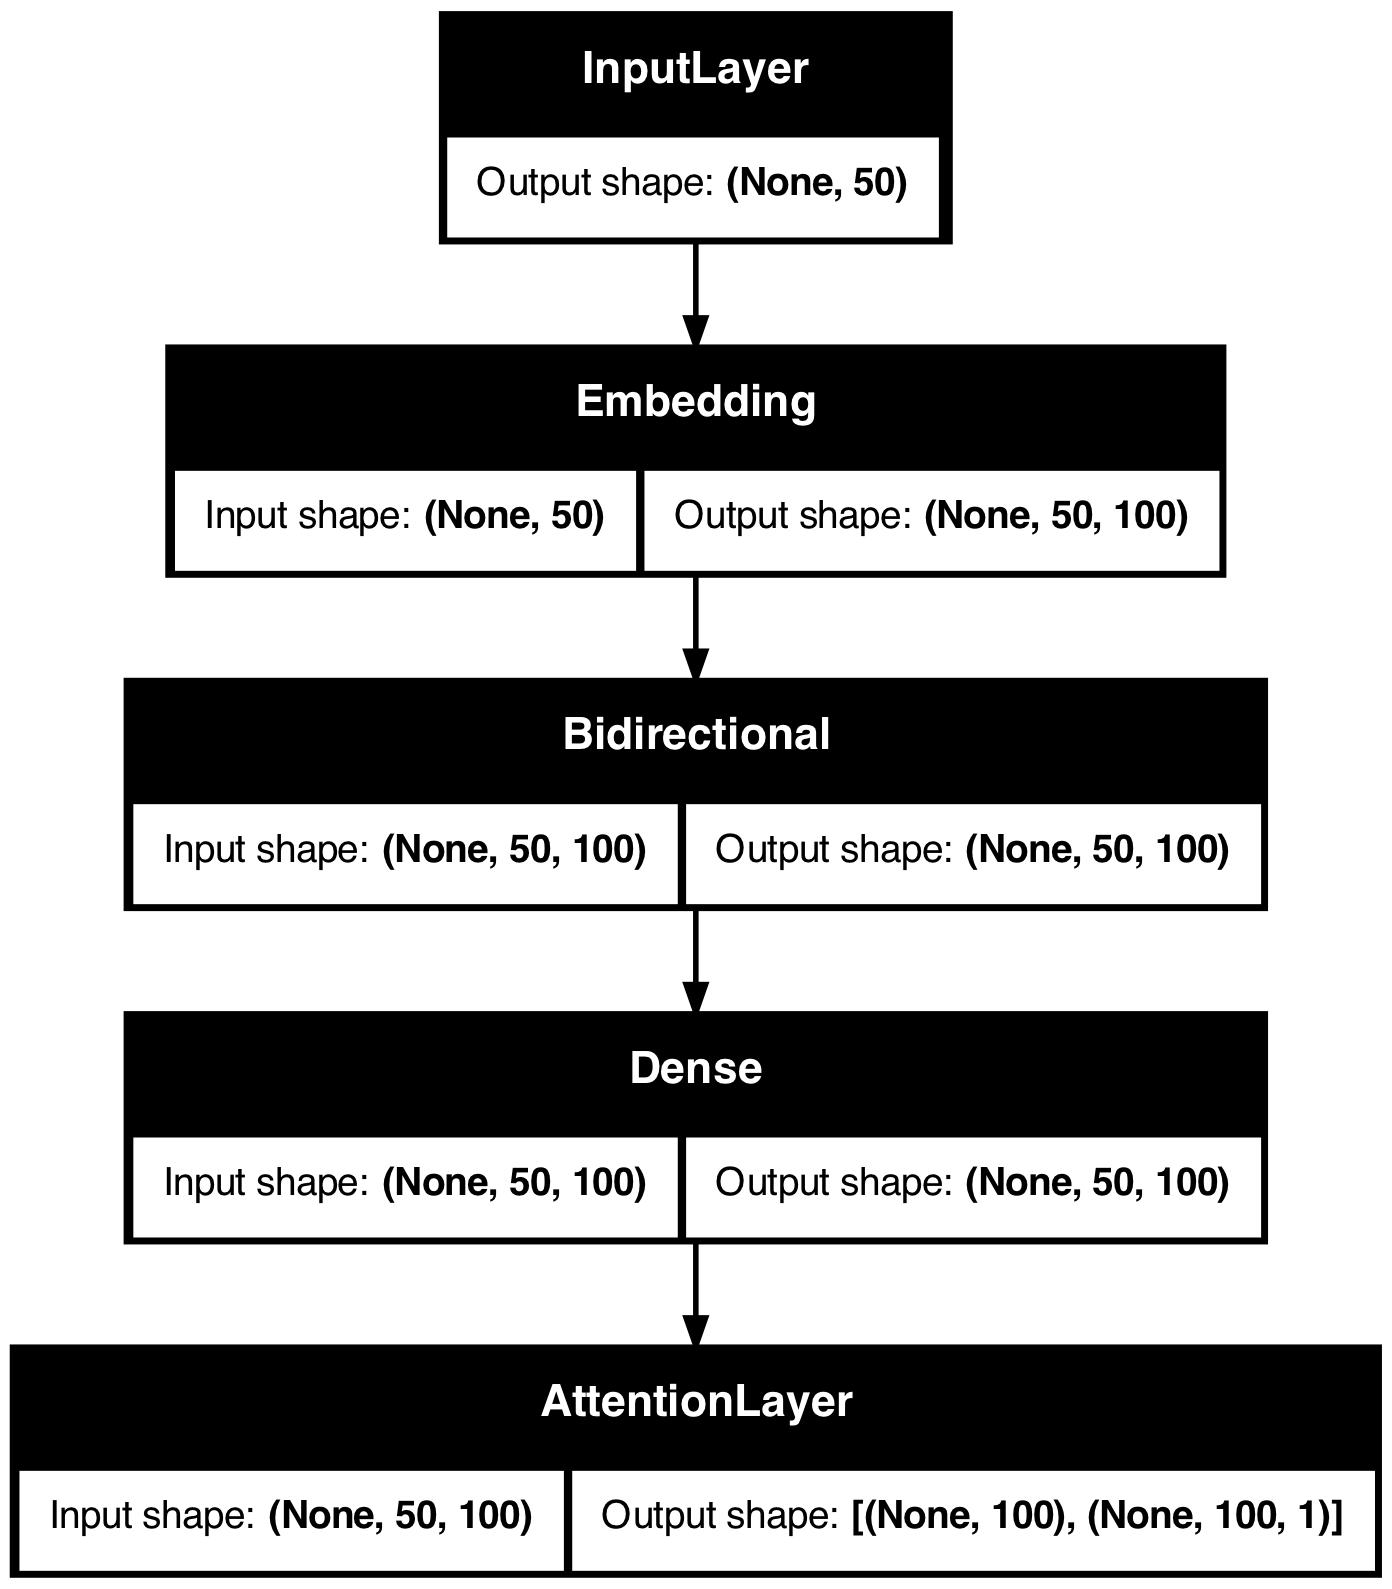

In [17]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

In [7]:
# Load the data using pickle
with open('train_data.pkl', 'rb') as f:
    x_train, y_train = pickle.load(f)

with open('val_data.pkl', 'rb') as f:
    x_val, y_val = pickle.load(f)

# TRAIN

Epoch 1/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 28430s 1s/step - acc: 0.4730 - loss: 1.2084 - val_acc: 0.5486 - val_loss: 1.0431
Epoch 2/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 31620s 1s/step - acc: 0.5306 - loss: 1.0894 - val_acc: 0.5622 - val_loss: 1.0128
Epoch 3/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 32255s 1s/step - acc: 0.5400 - loss: 1.0681 - val_acc: 0.5675 - val_loss: 1.0031
Epoch 4/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 28875s 1s/step - acc: 0.5456 - loss: 1.0549 - val_acc: 0.5693 - val_loss: 0.9948
Epoch 5/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 29038s 1s/step - acc: 0.5486 - loss: 1.0471 - val_acc: 0.5651 - val_loss: 1.0067
dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


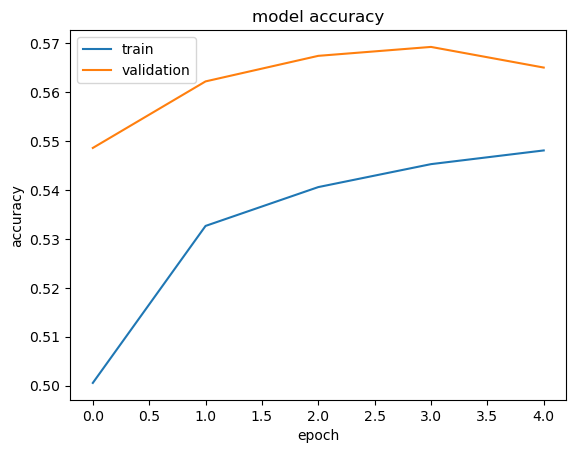

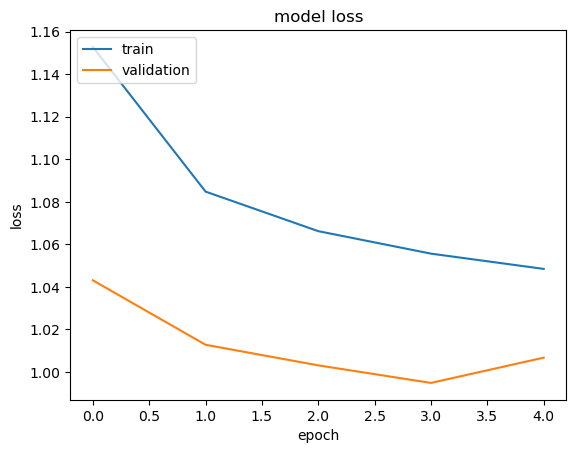

In [8]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
import pickle
with open('test_data.pkl', 'rb') as f:
    x_test, y_test = pickle.load(f)

In [20]:
model.evaluate(x=x_test, y=y_test, batch_size=None,verbose=1,sample_weight=None)

20313/20313 ━━━━━━━━━━━━━━━━━━━━ 4992s 245ms/step - acc: 0.5430 - loss: 1.0533


[1.0526612997055054, 0.5432800054550171]

In [12]:
model.save('Model_5epoch_amazon.h5')  